<a href="https://colab.research.google.com/github/HemantTiwariGitHub/Embedding2Embedding/blob/master/TheTrainerVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 try:
    %tensorflow_version 2.x
except:
    pass

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from absl import logging
import numpy as np
from PIL import Image as PIL_Image
from io import StringIO
import numpy as np
import PIL.Image as Image
import pathlib


print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.1.0-rc1
• Using TensorFlow Hub Version:  0.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [0]:

MOBILENET_V2_FEATURE_EXTRACTOR_URI = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
PIXEL =224
INPUT_IMAGE_SIZE = (PIXEL, PIXEL)
OUTPUT_FEATURE_VECTOR_SIZE = 1280
feature_extractor = hub.KerasLayer(MOBILENET_V2_FEATURE_EXTRACTOR_URI,
                                   input_shape=INPUT_IMAGE_SIZE + (3,), 
                                   output_shape=[OUTPUT_FEATURE_VECTOR_SIZE],
                                   trainable=False)
MobileNetModel = tf.keras.Sequential([
        feature_extractor
])

In [0]:
def resize_image(image):
    #print("resizing:") 
    resized_img = image.resize(INPUT_IMAGE_SIZE)
    #resized_img.show()
    resized_img_arr = np.array(resized_img)/255.0
    return resized_img_arr

def getImageEmbedding(regionImage, model):
    resizedImage = resize_image(regionImage)
    #plt.imshow(resizedImage)
    #plt.show()
    embedding = model.predict(resizedImage[np.newaxis, ...])
    #print(embedding)
    return embedding

In [0]:
def readImageFromDrive(imgId, regId):
    drivepath = '/content/drive/My Drive/'
    imagepath = drivepath +  'Region_Image/Image_' + str(imgId)+'_Region_' + str(regId)+'.jpg'
    imageName =  str(imgId) + '_' + str(regId)
    imageGet = tf.keras.utils.get_file(imageName, pathlib.Path(imagepath).as_uri())
    imageRead = Image.open(imageGet)
    return imageRead

In [7]:
imgReg = readImageFromDrive(125,2)
imgEmbedding = getImageEmbedding(imgReg, MobileNetModel )
print(imgEmbedding)

[[0.9606538  1.7073144  1.3611007  ... 0.5518554  0.07739219 0.47317785]]


In [0]:
def readTextFromDrive(imgId, regID):

    drivepath = '/content/drive/My Drive/'
    IembeddingPath = drivepath+'/Region_Descp'
    descpath =  drivepath + 'Region_Descp/Image_' + str(imgId)+'_Region_Descp' + str(regID)+'.txt'
    f = open(descpath, 'r')
    content = f.read()
    return content

In [0]:
def readEmbeddingFromDrive(imgId, regID):

    drivepath = '/content/drive/My Drive/'
    IembeddingPath = drivepath+'/Region_Descp'
    descpath =  drivepath + 'Image_Embedding/Image_' + str(imgId)+'_Embedding_'+ str(regID)+'.txt'
    f = open(descpath, 'r')
    content = f.read()
    return content


In [0]:
#!unzip <filename>

In [0]:
def getFileList(path):
    import glob,os
    iwd = os.getcwd()
    os.chdir(path)
    filelist= []
    for file in glob.glob("*.txt"):
        filelist.append(file)
    os.chdir(iwd)
    return filelist

In [0]:
import re
def getImageIDregID(str1):
    idList = list(map(int, re.findall('\d+',str1)))
    return idList

In [0]:
def getAllPairs(loadpath):
  ListOfFiles = getFileList(loadpath)
  ListOfID = []
  for filename in ListOfFiles:
    #print(filename)
    ID,REGID = getImageIDregID(filename)
    ListOfID.append([ID,REGID])
  return ListOfID

In [14]:
LOADING_PATH = "/content/Region_Descp"
ListOfIDs = getAllPairs(LOADING_PATH)

print(len(ListOfIDs))

56775


In [0]:
def LoadBatch(baseIndex, batchSize, sourceList):
    maxIndex = baseIndex + batchSize
    xList = []
    yList = []
    while (baseIndex < maxIndex):
        if (baseIndex%10==0):
          print("reading index : " + str(baseIndex))
        description = readTextFromDrive(sourceList[baseIndex][0], sourceList[baseIndex][1])
       # print("descp:" + description)
        x = embed([description])
        x1 = np.reshape(x, 512)

        #print("Text Embedding" + str(x1))
        #print (x1.shape)
        

        imgReg = readImageFromDrive(sourceList[baseIndex][0], sourceList[baseIndex][1])
       # display(imgReg)
        y = getImageEmbedding(imgReg, MobileNetModel )
        y1 = np.reshape(y, 1280)
        #print("Image Embedding" + str(y1))
        #print ("Yshape" + str(y1.shape))
        xList.append(x1)
        yList.append(y1)
        baseIndex = baseIndex + 1

    return xList,yList

In [42]:
import numpy as np
np.set_printoptions(threshold=10)
X,Y = LoadBatch(0, 1000, ListOfIDs)
X = np.asarray(X)
Y = np.asarray(Y)
print(X.shape)
print(Y.shape)

reading index : 0
reading index : 10
reading index : 20
reading index : 30
reading index : 40
reading index : 50
reading index : 60
reading index : 70
reading index : 80
reading index : 90
reading index : 100
reading index : 110
reading index : 120
reading index : 130
reading index : 140
reading index : 150
reading index : 160
reading index : 170
reading index : 180
reading index : 190
reading index : 200
reading index : 210
reading index : 220
reading index : 230
reading index : 240
reading index : 250
reading index : 260
reading index : 270
reading index : 280
reading index : 290
reading index : 300
reading index : 310
reading index : 320
reading index : 330
reading index : 340
reading index : 350
reading index : 360
reading index : 370
reading index : 380
reading index : 390
reading index : 400
reading index : 410
reading index : 420
reading index : 430
reading index : 440
reading index : 450
reading index : 460
reading index : 470
reading index : 480
reading index : 490
reading ind

In [43]:
print(X)

[[ 0.03020312  0.0755768  -0.03746407 ...  0.03053355  0.01503169
  -0.00533399]
 [-0.0077608   0.05888794  0.00815242 ... -0.00472368 -0.07115692
   0.03192245]
 [ 0.00399121  0.03260137  0.00750925 ... -0.05466543 -0.0229566
  -0.0146247 ]
 ...
 [ 0.02849898  0.04417047 -0.01633866 ...  0.02346408 -0.01772887
  -0.02321855]
 [-0.04691355  0.01009963  0.00645433 ... -0.01594912  0.00914258
   0.01090833]
 [ 0.00050116  0.0443732  -0.05073781 ...  0.03648134  0.05847602
  -0.00366473]]


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.keras.backend.clear_session() 

In [45]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(512,), name='TextEmbedding')
layer2 = layers.Dense(1024,activation='relu', name='dense_1')(inputs)
layer3 = layers.Dense(1024, activation='relu', name='dense_2')(layer2)
outputVector = layers.Dense(1280, activation= 'tanh', name='Predictions')(layer3)

model = keras.Model(inputs=inputs, outputs=outputVector)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TextEmbedding (InputLayer)   [(None, 512)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
Predictions (Dense)          (None, 1280)              1312000   
Total params: 2,886,912
Trainable params: 2,886,912
Non-trainable params: 0
_________________________________________________________________


In [56]:
validationSetSize =int(len(X)/10)
print("ValidationSet Size : " + str(validationSetSize))
x_val = X[-validationSetSize:]
y_val = Y[-validationSetSize:]
x_train = X[:-validationSetSize]
y_train = Y[:-validationSetSize]


#for y1 in y1_train:
   # y_train.append(tf.convert_to_tensor(y1))




#x_train = np.asarray(x_train,dtype="float32", order=None)
#y_train = np.asarray (y_train,dtype="float32", order=None)
#x_train = tf.convert_to_tensor(x_train)
print(x_train.shape)
print(y_train.shape)
#print(y_train[0])


#model.summary()

ValidationSet Size : 100
(900, 512)
(900, 1280)


In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.CosineSimilarity(),
              # List of metrics to monitor
              metrics=[keras.metrics.CosineSimilarity()])


In [54]:
print('# Fit model on training data')
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                   )

# Fit model on training data
Train on 900 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/sample - loss: -0.5640 - cosine_similarity: 0.5640
Epoch 2/100
900/900 [==============================] - 1s 783us/sample - loss: -0.6360 - cosine_similarity: 0.6360
Epoch 3/100
900/900 [==============================] - 1s 845us/sample - loss: -0.6542 - cosine_similarity: 0.6542
Epoch 4/100
900/900 [==============================] - 1s 799us/sample - loss: -0.6731 - cosine_similarity: 0.6731
Epoch 5/100
900/900 [==============================] - 1s 851us/sample - loss: -0.6929 - cosine_similarity: 0.6929
Epoch 6/100
900/900 [==============================] - 1s 885us/sample - loss: -0.7156 - cosine_similarity: 0.7156
Epoch 7/100
900/900 [==============================] - 1s 885us/sample - loss: -0.7385 - cosine_similarity: 0.7385
Epoch 8/100
900/900 [==============================] - 1s 844us/sample - loss: -0.7533 - cosine_similarity: 0.7533
Epoch 9/100
900/900 [===========

In [60]:
y = model.predict(x_val)
print (y.shape)
print(y[0])
print(y_val[0])


(100, 1280)
[ 0.00422466  0.04605269  0.01528466 ...  0.02639722 -0.00235608
  0.30709773]
[0.         0.5715288  0.         ... 0.01793216 0.         0.9757645 ]


Using TensorFlow backend.


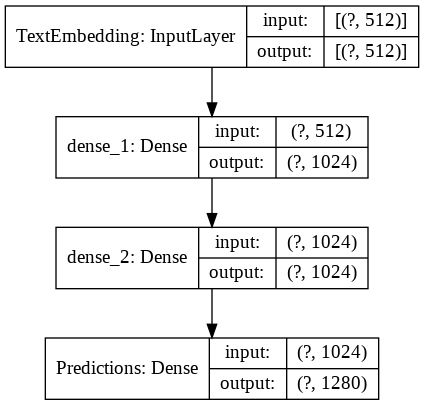

In [61]:
from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names=True,expand_nested= True)